In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

In [3]:
sns.set(style='whitegrid')
data=pd.read_csv('Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv')

print('Shape of dataset:', data.shape)
data.columns = data.columns.str.strip()
print('Columns of dataset: ', data.columns.values)

Shape of dataset: (225745, 85)
Columns of dataset:  ['Flow ID' 'Source IP' 'Source Port' 'Destination IP' 'Destination Port'
 'Protocol' 'Timestamp' 'Flow Duration' 'Total Fwd Packets'
 'Total Backward Packets' 'Total Length of Fwd Packets'
 'Total Length of Bwd Packets' 'Fwd Packet Length Max'
 'Fwd Packet Length Min' 'Fwd Packet Length Mean' 'Fwd Packet Length Std'
 'Bwd Packet Length Max' 'Bwd Packet Length Min' 'Bwd Packet Length Mean'
 'Bwd Packet Length Std' 'Flow Bytes/s' 'Flow Packets/s' 'Flow IAT Mean'
 'Flow IAT Std' 'Flow IAT Max' 'Flow IAT Min' 'Fwd IAT Total'
 'Fwd IAT Mean' 'Fwd IAT Std' 'Fwd IAT Max' 'Fwd IAT Min' 'Bwd IAT Total'
 'Bwd IAT Mean' 'Bwd IAT Std' 'Bwd IAT Max' 'Bwd IAT Min' 'Fwd PSH Flags'
 'Bwd PSH Flags' 'Fwd URG Flags' 'Bwd URG Flags' 'Fwd Header Length'
 'Bwd Header Length' 'Fwd Packets/s' 'Bwd Packets/s' 'Min Packet Length'
 'Max Packet Length' 'Packet Length Mean' 'Packet Length Std'
 'Packet Length Variance' 'FIN Flag Count' 'SYN Flag Count'
 'RST Fla

In [4]:
print('Gaps or infinities per columns:')
numeric_cols = data.select_dtypes(include=[np.number])
missing = data.isnull().sum()
inf = np.isinf(numeric_cols).sum()

print(missing[missing>0])
print(inf[inf>0])

Gaps or infinities per columns:
Flow Bytes/s    4
dtype: int64
Flow Bytes/s      30
Flow Packets/s    34
dtype: int64


In [5]:
data = data.replace([np.inf, -np.inf], np.nan)

for col in ['Flow Bytes/s', 'Flow Packets/s']:
    data[col] = data[col].fillna(data[col].median())
    
print(data.isnull().sum().sum())

0


In [6]:
target_col = 'Label'
data[target_col].unique()

array(['BENIGN', 'DDoS'], dtype=object)

In [7]:
data[target_col] = data[target_col].factorize()[0]
data[target_col][:100000:10000]

0        0
10000    0
20000    1
30000    1
40000    0
50000    0
60000    0
70000    0
80000    1
90000    1
Name: Label, dtype: int64

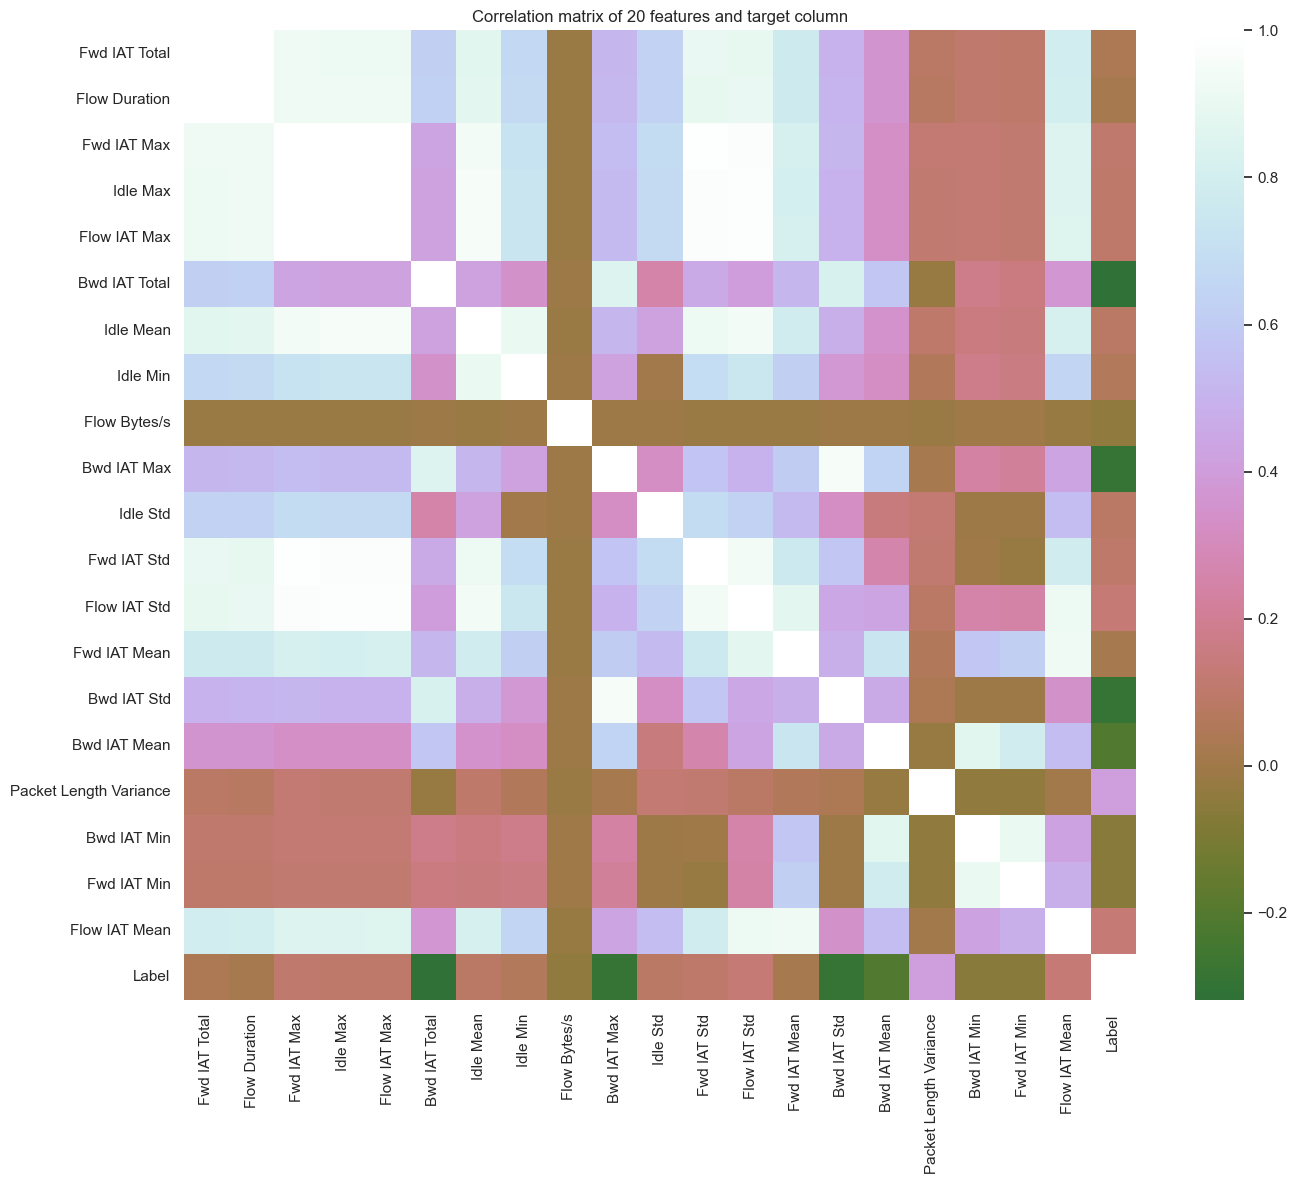

In [44]:
num_cols = data.select_dtypes(include=[np.number]).columns.tolist()
corr_cols = num_cols.copy()
if len(corr_cols) > 20:
    variances = data[corr_cols].var().sort_values(ascending=False)
    corr_cols = variances.index[:20].tolist()

corr_cols+=[target_col]

plt.figure(figsize=(14, 12))
corr = data[corr_cols].corr()
sns.heatmap(corr, cmap=sns.color_palette("cubehelix", as_cmap=True), center=0, annot=False)
plt.title('Correlation matrix of 20 features and target column')
plt.tight_layout()
plt.show()

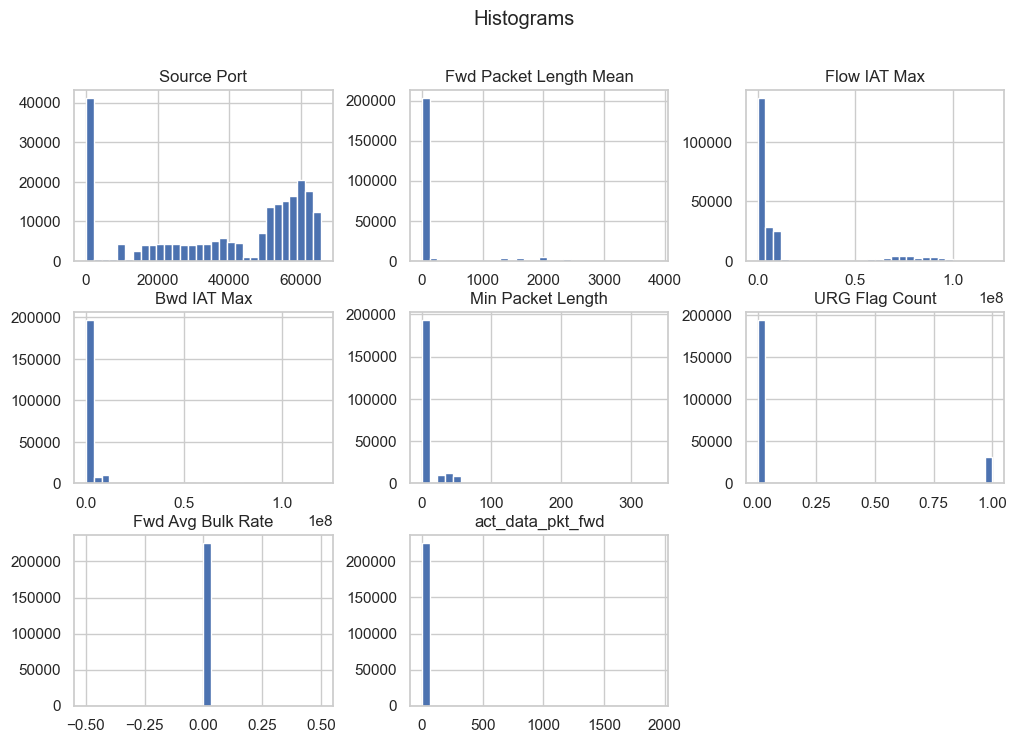

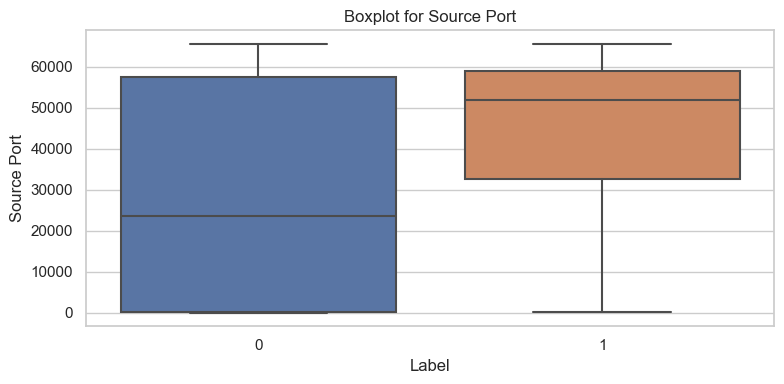

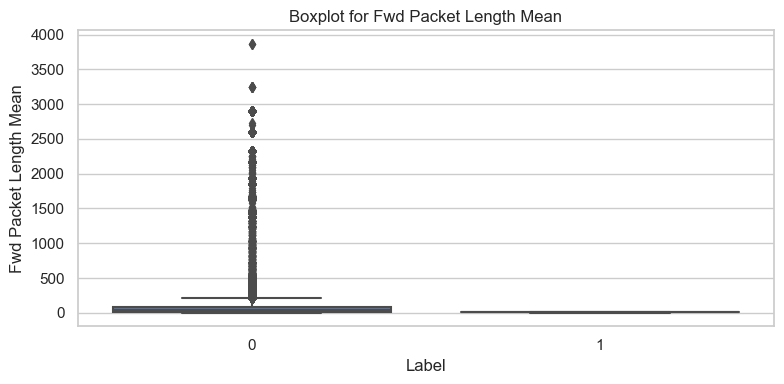

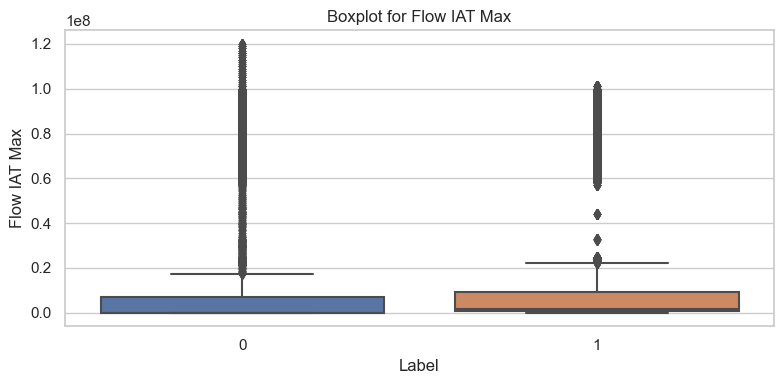

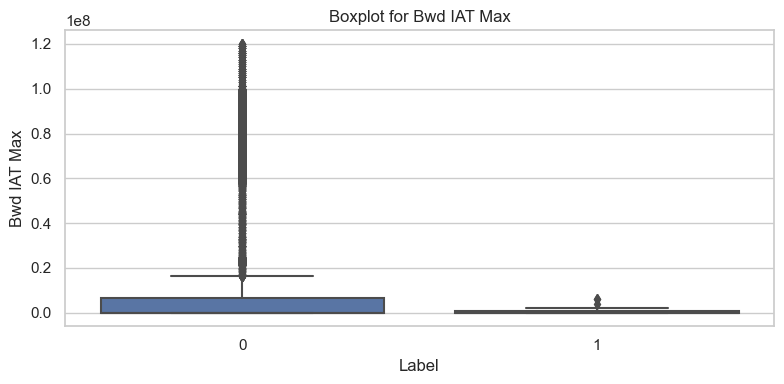

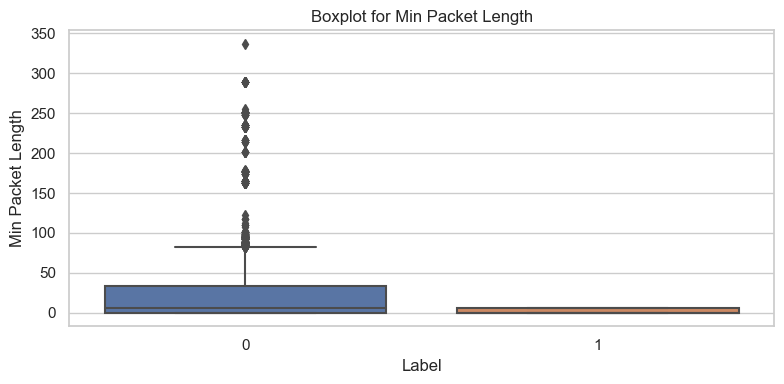

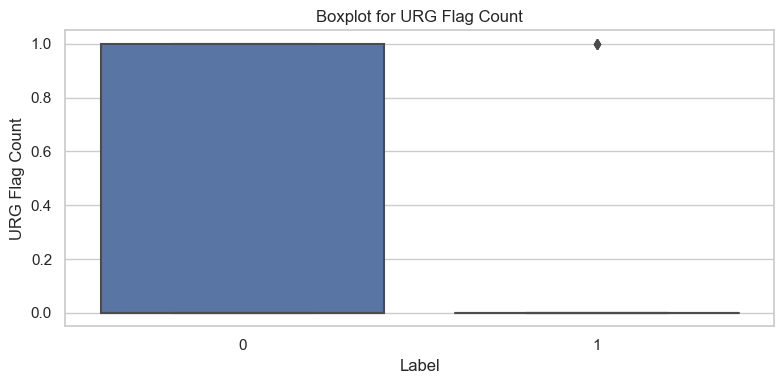

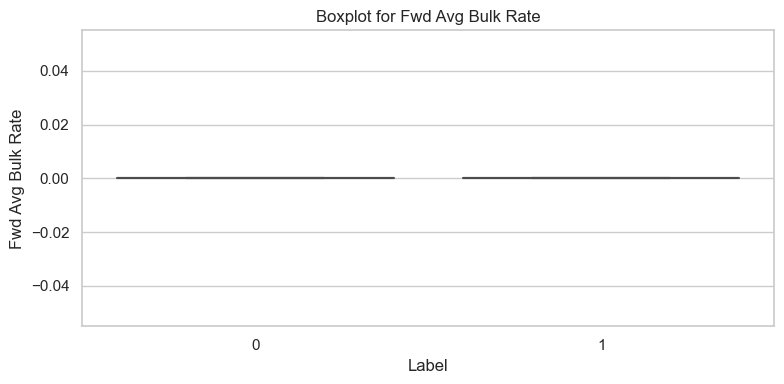

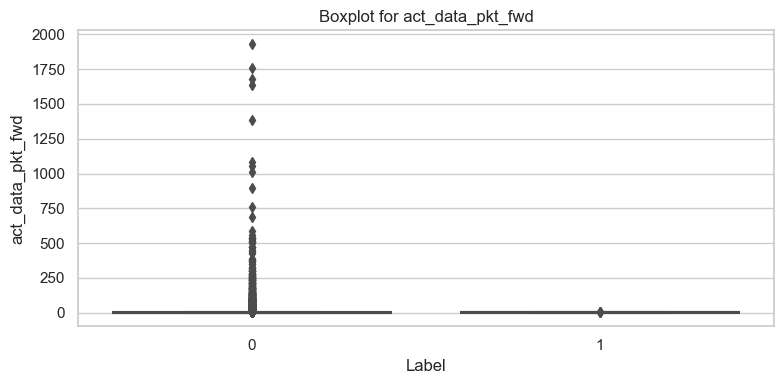

In [9]:
plot_cols = [c for c in num_cols if c != target_col][::10]
data[plot_cols].hist(bins=30, figsize=(12, 8))
plt.suptitle('Histograms')
plt.show()

for c in plot_cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=data[target_col], y=data[c])
    plt.title(f'Boxplot for {c}')
    plt.tight_layout()
    plt.show()

In [34]:
features = data.select_dtypes(include=[np.number]).columns.tolist()
X_cols = [c for c in features if c != target_col]

df_small = data[X_cols + [target_col]].copy()
min_class_size = 10000
balanced_df = (
    df_small.groupby(target_col, group_keys=False)
    .sample(n=min_class_size, random_state=42)
)

balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

X = balanced_df[X_cols]
y = balanced_df[target_col]

print('Feature :', features)
print('X :', X.shape)
print('y :',y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print('X_train :', X_train.shape)
print('y_train :',y_train.shape)
print('X_test :', X_test.shape)
print('y_test :',y_test.shape)

Feature : ['Source Port', 'Destination Port', 'Protocol', 'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Total Length of Fwd Packets', 'Total Length of Bwd Packets', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s', 'Min Packet Length', 'Max Packet Length', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count', 'URG Flag Coun

In [35]:
def evaluate_model(clf, X_tr, X_te, y_tr, y_te, model_name='model'):
    clf.fit(X_tr, y_tr)
    y_pred = clf.predict(X_te)
    print('\n===', model_name, '===')
    print('Classification report:')
    print(classification_report(y_te, y_pred))
    cm = confusion_matrix(y_te, y_pred)
    print('Confusion matrix:\n', cm)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, cmap=sns.diverging_palette(145, 300, s=60, as_cmap=True), fmt='d')
    plt.title(f'Confusion matrix: {model_name}')
    plt.show()
    return clf, classification_report(y_te, y_pred, output_dict=True), cm


KNN best params: {'knn__n_neighbors': 3, 'knn__weights': 'distance'} ; best score: 0.9993124999328613

=== КNN ===
Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2000
           1       1.00      1.00      1.00      2000

    accuracy                           1.00      4000
   macro avg       1.00      1.00      1.00      4000
weighted avg       1.00      1.00      1.00      4000

Confusion matrix:
 [[1999    1]
 [   0 2000]]


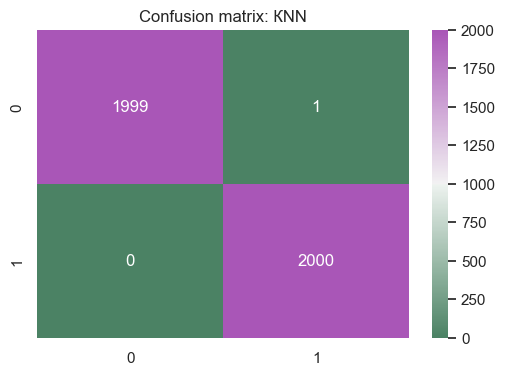

In [45]:
results = {}

knn_pipe = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier())])
knn_params = {
    'knn__n_neighbors': [3,5,7,9],
    'knn__weights': ['uniform', 'distance']
}
cross_val = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
knn_gs = GridSearchCV(knn_pipe, knn_params, cv=cross_val, n_jobs=-1, scoring='f1_macro')
knn_gs.fit(X_train, y_train)
print('KNN best params:', knn_gs.best_params_, '; best score:', knn_gs.best_score_)
best_knn = knn_gs.best_estimator_
res_knn = evaluate_model(best_knn, X_train, X_test, y_train, y_test, 'КNN')
results['KNN'] = {'model': best_knn, 'report': res_knn[1], 'cm': res_knn[2], 'best_params': knn_gs.best_params_}

DecisionTree best params: {'dt__max_depth': 5, 'dt__min_samples_split': 2} ; best score: 0.99899999946289

=== DecisionTree ===
Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2000
           1       1.00      1.00      1.00      2000

    accuracy                           1.00      4000
   macro avg       1.00      1.00      1.00      4000
weighted avg       1.00      1.00      1.00      4000

Confusion matrix:
 [[1999    1]
 [   5 1995]]


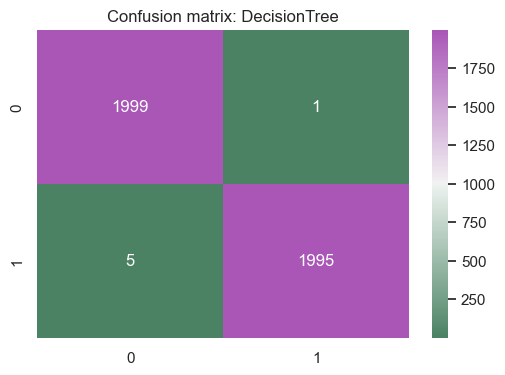

In [47]:
dt_pipe = Pipeline([('scaler', StandardScaler()), ('dt', DecisionTreeClassifier(random_state=42))])
dt_params = {'dt__max_depth': [None, 5, 10, 20], 'dt__min_samples_split': [2,5,10]}
dt_gs = GridSearchCV(dt_pipe, dt_params, cv=cross_val, n_jobs=-1, scoring='f1_macro')
dt_gs.fit(X_train, y_train)
print('DecisionTree best params:', dt_gs.best_params_, '; best score:', dt_gs.best_score_)
best_dt = dt_gs.best_estimator_
res_dt = evaluate_model(best_dt, X_train, X_test, y_train, y_test, 'DecisionTree')
results['DecisionTree'] = {'model': best_dt, 'report': res_dt[1], 'cm': res_dt[2], 'best_params': dt_gs.best_params_}

SVM best params: {'svm__C': 10, 'svm__gamma': 'scale'} ; best score: 0.9991874997741697

=== SVM ===
Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2000
           1       1.00      1.00      1.00      2000

    accuracy                           1.00      4000
   macro avg       1.00      1.00      1.00      4000
weighted avg       1.00      1.00      1.00      4000

Confusion matrix:
 [[1998    2]
 [   1 1999]]


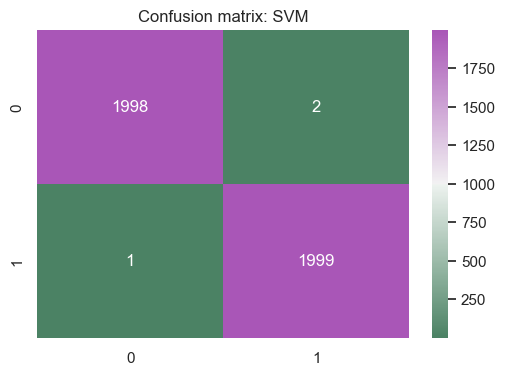

In [48]:
svm_pipe = Pipeline([('scaler', StandardScaler()), ('svm', SVC(kernel='rbf', probability=True))])
svm_params = {'svm__C': [0.1, 1, 10], 'svm__gamma': ['scale', 'auto', 0.01, 0.001]}
svm_gs = GridSearchCV(svm_pipe, svm_params, cv=cross_val, n_jobs=-1, scoring='f1_macro')
svm_gs.fit(X_train, y_train)
print('SVM best params:', svm_gs.best_params_, '; best score:', svm_gs.best_score_)
best_svm = svm_gs.best_estimator_
res_svm = evaluate_model(best_svm, X_train, X_test, y_train, y_test, 'SVM')
results['SVM'] = {'model': best_svm, 'report': res_svm[1], 'cm': res_svm[2], 'best_params': svm_gs.best_params_}

RandomForest best params: {'rf__max_depth': None, 'rf__n_estimators': 100} ; best score: 0.9995624995910639

=== RandomForest ===
Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2000
           1       1.00      1.00      1.00      2000

    accuracy                           1.00      4000
   macro avg       1.00      1.00      1.00      4000
weighted avg       1.00      1.00      1.00      4000

Confusion matrix:
 [[1999    1]
 [   1 1999]]


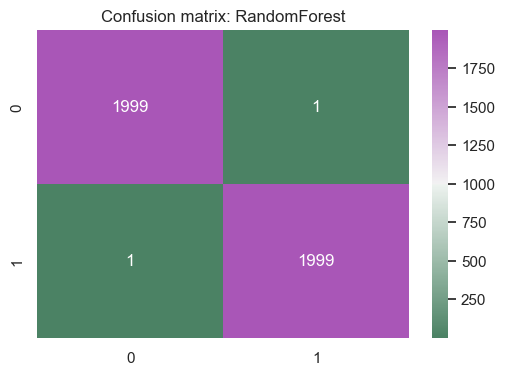

In [49]:
rf_pipe = Pipeline([('scaler', StandardScaler()), ('rf', RandomForestClassifier(random_state=42))])
rf_params = {'rf__n_estimators': [100, 200], 'rf__max_depth': [None, 10, 20]}
rf_gs = GridSearchCV(rf_pipe, rf_params, cv=cross_val, n_jobs=-1, scoring='f1_macro')
rf_gs.fit(X_train, y_train)
print('RandomForest best params:', rf_gs.best_params_, '; best score:', rf_gs.best_score_)
best_rf = rf_gs.best_estimator_
res_rf = evaluate_model(best_rf, X_train, X_test, y_train, y_test, 'RandomForest')
results['RandomForest'] = {'model': best_rf, 'report': res_rf[1], 'cm': res_rf[2], 'best_params': rf_gs.best_params_}

AdaBoost best params: {'ab__learning_rate': 1.0, 'ab__n_estimators': 100} ; best score: 0.9996874999328613

=== AdaBoost ===
Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2000
           1       1.00      1.00      1.00      2000

    accuracy                           1.00      4000
   macro avg       1.00      1.00      1.00      4000
weighted avg       1.00      1.00      1.00      4000

Confusion matrix:
 [[2000    0]
 [   1 1999]]


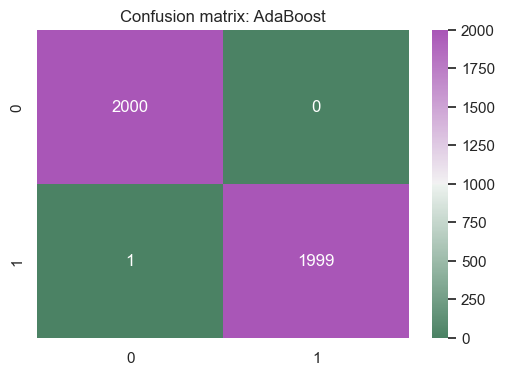

In [50]:
ab_pipe = Pipeline([('scaler', StandardScaler()), ('ab', AdaBoostClassifier(random_state=42, algorithm='SAMME'))])
ab_params = {'ab__n_estimators': [50, 100], 'ab__learning_rate': [0.5, 1.0]}
ab_gs = GridSearchCV(ab_pipe, ab_params, cv=cross_val, n_jobs=-1, scoring='f1_macro')
ab_gs.fit(X_train, y_train)
print('AdaBoost best params:', ab_gs.best_params_, '; best score:', ab_gs.best_score_)
best_ab = ab_gs.best_estimator_
res_ab = evaluate_model(best_ab, X_train, X_test, y_train, y_test, 'AdaBoost')
results['AdaBoost'] = {'model': best_ab, 'report': res_ab[1], 'cm': res_ab[2], 'best_params': ab_gs.best_params_}

In [51]:
best_model_name = None
best_f1 = -1
for name, info in results.items():
    rep = info['report']
    f1_macro = rep['macro avg']['f1-score']
  
    print(f"{name}: best_params={info['best_params']}, f1_macro={f1_macro}")
    if f1_macro is not None and f1_macro > best_f1:
        best_f1 = f1_macro
        best_model_name = name

print('The best model for this dataset by f1_macro :', best_model_name)

KNN: best_params={'knn__n_neighbors': 3, 'knn__weights': 'distance'}, f1_macro=0.9997499999843751
DecisionTree: best_params={'dt__max_depth': 5, 'dt__min_samples_split': 2}, f1_macro=0.9984999984999985
SVM: best_params={'svm__C': 10, 'svm__gamma': 'scale'}, f1_macro=0.999249999953125
RandomForest: best_params={'rf__max_depth': None, 'rf__n_estimators': 100}, f1_macro=0.9995
AdaBoost: best_params={'ab__learning_rate': 1.0, 'ab__n_estimators': 100}, f1_macro=0.9997499999843751
The best model for this dataset by f1_macro : KNN
